In [1]:
# coding: utf-8

# In[7]:

import sys,os
import numpy as np
import dicom
import glob
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import time
from sklearn import cross_validation
from lightgbm.sklearn import LGBMRegressor
from resnet50 import ResNet50
from keras.preprocessing import image
#from imagenet_utils import preprocess_input
#from PIL import Image
#from resizeimage import resizeimage

/a/data/mango/environments/newtf/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/a/data/mango/environments/newtf/lib/python2.7/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/a/data/mango/environments/newtf/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this mo

In [15]:
import errno
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
EXPERIMENT_NUMBER = 'resNet' 

#Put here the path where you downloaded all kaggle data
DATA_PATH='data/'

# Path and variables
STAGE1_LABELS=DATA_PATH + 'stage1_labels.csv'
STAGE1_SAMPLE_SUBMISSION=DATA_PATH + 'stage1_sample_submission.csv'
STAGE1_SAMPLE_SUBMISSION_2=DATA_PATH + 'stage1_sample_avg_submission.csv'
STAGE1_FOLDER=DATA_PATH + 'stage1/'
FEATURE_FOLDER=DATA_PATH + 'features/features' + EXPERIMENT_NUMBER + '/'
SUBMIT_OUTPUT='submit' + EXPERIMENT_NUMBER + '_label_image.csv'
SUBMIT_OUTPUT_2='submit' + EXPERIMENT_NUMBER + '_label_image_Avg.csv'
SUBMIT_OUTPUT_3='submit' + EXPERIMENT_NUMBER + '_label_image_Max.csv'
SUBMIT_OUTPUT_4='submit' + EXPERIMENT_NUMBER + '_label_image_Min.csv'
make_sure_path_exists(FEATURE_FOLDER)

In [3]:
# Timer class
class Timer(object):
    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def start(self):
        self.start = time.clock()

    def stop(self):
        self.end = time.clock()
        self.interval = self.end - self.start


In [4]:
def get_3d_data(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

In [5]:
def get_data_id(path, plot_data=False):
    sample_image = get_3d_data(path)
    sample_image[sample_image == -2000] = 0
    #if plot_data:
    #    f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))

    batch = []
    cnt = 0
    dx = 40
    ds = 512
    for i in range(0, sample_image.shape[0] - 3, 3):
        tmp = []
        for j in range(3):
            img = sample_image[i + j]
            img = 255.0 / np.amax(img) * img
            img = cv2.equalizeHist(img.astype(np.uint8))
            img = img.astype(np.uint8)
            img = img[dx: ds - dx, dx: ds - dx]
            img = cv2.resize(img, (224, 224))
            #img = resizeimage.resize_crop(img, [224, 224])
            #img = np.resize(img, (224,224))
            tmp.append(img)

        tmp = np.array(tmp)
        tmp = np.swapaxes(tmp,0,2) #we need to make "color" dimension last I think
        batch.append(np.array(tmp))

#         if plot_data:
#             if cnt < 20:
#                 plots[cnt // 5, cnt % 5].axis('off')
#                 plots[cnt // 5, cnt % 5].imshow(tmp[0,:,:], cmap='gray')
#             cnt += 1

#     if plot_data: plt.show()
        
    batch = np.array(batch, dtype='int')
    return batch



In [6]:
def get_model():
    model = ResNet50(weights='imagenet', include_top=False)
    return model

In [7]:
def calc_features(verbose=False):
    model = get_model()
    for folder in glob.glob(STAGE1_FOLDER+'*'):
        foldername = os.path.basename(folder)
        if os.path.isfile(FEATURE_FOLDER+foldername+'.npy'):
            if verbose: print("Features in %s already computed" % (FEATURE_FOLDER+foldername))
            continue
        batch = get_data_id(folder)
        if verbose:
            print("Batch size:")
            print(batch.shape)
        feats = model.predict(batch, batch_size=52, verbose=1)

        if verbose:
            print(feats.shape)
            print("Saving features in %s" % (FEATURE_FOLDER+foldername))
        np.save(FEATURE_FOLDER+foldername, feats)

In [8]:
        
#%%time
# Calculate features
calc_features(verbose=False)

38/38 [==============================] - 0s


40/40 [==============================] - 0s


57/57 [==============================] - 0s     


41/41 [==============================] - 0s


89/89 [==============================] - 1s     


In [8]:
# In[25]:
global x
global y
def train_lightgbm():
    df = pd.read_csv(STAGE1_LABELS)
    """
    x = np.array([np.mean(np.load(FEATURE_FOLDER+'%s.npy' % str(id)), axis=0).flatten() for id in df['id'].tolist()])
    y = df['cancer'].as_matrix()
    """
    image_num = 0
    df_2 = df['cancer'].tolist()
    print 'length of df_2', len(df_2)
    i = 0
    #x = []
    for id in df['id']:
        load_one = np.array([np.load(FEATURE_FOLDER+'%s.npy' %str(id))])
#         print 'load_one shape: ', load_one.shape (1,64,7,7,512)
        a,b,c,d,e = load_one.shape
        load_one = load_one.reshape(a*b, c*d*e)
        if i == 0:
            x = load_one
        else:
            x = np.vstack((x,load_one))
#         print 'load one shape', load_one.shape
#         print 'x shape:', x.shape
        image_num += b
#         print 'lenght of df before', len(df_2)
        df_2[i:i] = [df_2[i]] * (b-1)
        i = image_num
#         print 'length of df_2', len(df_2[:i])
    y = np.array(df_2)
    print 'x.shape', x.shape
    print 'y.shape', y.shape
    
    trn_x, val_x, trn_y, val_y = cross_validation.train_test_split(x, y, random_state=42, stratify=y,
                                                                   test_size=0.20)
    clf = LGBMRegressor(max_depth=50,
                        num_leaves=21,
                        n_estimators=5000,
                        min_child_weight=1,
                        learning_rate=0.001,
                        nthread=24,
                        subsample=0.80,
                        colsample_bytree=0.80,
                        seed=42)
    clf.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], verbose=True, eval_metric='l2', early_stopping_rounds=900)
    return clf

In [9]:
def compute_training(verbose=True):
    with Timer() as t:
        clf = train_lightgbm()
    if verbose: print("Training took %.03f sec.\n" % t.interval)
    return clf

In [10]:
def compute_prediction(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION)
    x = np.array([np.mean(np.load((FEATURE_FOLDER+'%s.npy') % str(id)), axis=0).flatten() for id in df['id'].tolist()])
    
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    print pred
    df['cancer'] = pred
    return df

In [11]:
def save_results(df):
    df.to_csv(SUBMIT_OUTPUT, index=False)

In [10]:
clf = compute_training(verbose=True)

length of df_2 1397
x.shape (81942, 2048)
y.shape (81942,)
[1]	valid_0's l2: 0.523423
Train until valid scores didn't improve in 900 rounds.
[2]	valid_0's l2: 0.523254
[3]	valid_0's l2: 0.523086
[4]	valid_0's l2: 0.522919
[5]	valid_0's l2: 0.522752
[6]	valid_0's l2: 0.522585
[7]	valid_0's l2: 0.522417
[8]	valid_0's l2: 0.522252
[9]	valid_0's l2: 0.522087
[10]	valid_0's l2: 0.521922
[11]	valid_0's l2: 0.521754
[12]	valid_0's l2: 0.52159
[13]	valid_0's l2: 0.521426
[14]	valid_0's l2: 0.521264
[15]	valid_0's l2: 0.521101
[16]	valid_0's l2: 0.520938
[17]	valid_0's l2: 0.520773
[18]	valid_0's l2: 0.52061
[19]	valid_0's l2: 0.520446
[20]	valid_0's l2: 0.520284
[21]	valid_0's l2: 0.52012
[22]	valid_0's l2: 0.519958
[23]	valid_0's l2: 0.519794
[24]	valid_0's l2: 0.519631
[25]	valid_0's l2: 0.519469
[26]	valid_0's l2: 0.519308
[27]	valid_0's l2: 0.519148
[28]	valid_0's l2: 0.518989
[29]	valid_0's l2: 0.518828
[30]	valid_0's l2: 0.518667
[31]	valid_0's l2: 0.518507
[32]	valid_0's l2: 0.518347
[3

[285]	valid_0's l2: 0.485275
[286]	valid_0's l2: 0.48517
[287]	valid_0's l2: 0.485065
[288]	valid_0's l2: 0.484959
[289]	valid_0's l2: 0.484853
[290]	valid_0's l2: 0.484749
[291]	valid_0's l2: 0.484644
[292]	valid_0's l2: 0.484537
[293]	valid_0's l2: 0.484435
[294]	valid_0's l2: 0.484332
[295]	valid_0's l2: 0.484228
[296]	valid_0's l2: 0.484124
[297]	valid_0's l2: 0.484022
[298]	valid_0's l2: 0.48392
[299]	valid_0's l2: 0.483817
[300]	valid_0's l2: 0.483715
[301]	valid_0's l2: 0.483611
[302]	valid_0's l2: 0.483509
[303]	valid_0's l2: 0.483407
[304]	valid_0's l2: 0.483303
[305]	valid_0's l2: 0.4832
[306]	valid_0's l2: 0.4831
[307]	valid_0's l2: 0.483
[308]	valid_0's l2: 0.4829
[309]	valid_0's l2: 0.482799
[310]	valid_0's l2: 0.482699
[311]	valid_0's l2: 0.482597
[312]	valid_0's l2: 0.482496
[313]	valid_0's l2: 0.482393
[314]	valid_0's l2: 0.482293
[315]	valid_0's l2: 0.482193
[316]	valid_0's l2: 0.482094
[317]	valid_0's l2: 0.481996
[318]	valid_0's l2: 0.481898
[319]	valid_0's l2: 0.481

[569]	valid_0's l2: 0.46159
[570]	valid_0's l2: 0.461525
[571]	valid_0's l2: 0.461459
[572]	valid_0's l2: 0.461395
[573]	valid_0's l2: 0.461331
[574]	valid_0's l2: 0.461267
[575]	valid_0's l2: 0.461203
[576]	valid_0's l2: 0.461139
[577]	valid_0's l2: 0.461075
[578]	valid_0's l2: 0.461014
[579]	valid_0's l2: 0.46095
[580]	valid_0's l2: 0.460886
[581]	valid_0's l2: 0.460824
[582]	valid_0's l2: 0.460761
[583]	valid_0's l2: 0.460698
[584]	valid_0's l2: 0.460635
[585]	valid_0's l2: 0.460571
[586]	valid_0's l2: 0.460508
[587]	valid_0's l2: 0.460444
[588]	valid_0's l2: 0.460381
[589]	valid_0's l2: 0.46032
[590]	valid_0's l2: 0.460256
[591]	valid_0's l2: 0.460193
[592]	valid_0's l2: 0.460131
[593]	valid_0's l2: 0.460069
[594]	valid_0's l2: 0.460006
[595]	valid_0's l2: 0.459945
[596]	valid_0's l2: 0.459883
[597]	valid_0's l2: 0.459822
[598]	valid_0's l2: 0.45976
[599]	valid_0's l2: 0.459699
[600]	valid_0's l2: 0.459638
[601]	valid_0's l2: 0.459578
[602]	valid_0's l2: 0.459517
[603]	valid_0's l2

[853]	valid_0's l2: 0.446993
[854]	valid_0's l2: 0.446953
[855]	valid_0's l2: 0.446912
[856]	valid_0's l2: 0.446872
[857]	valid_0's l2: 0.446831
[858]	valid_0's l2: 0.44679
[859]	valid_0's l2: 0.446749
[860]	valid_0's l2: 0.446709
[861]	valid_0's l2: 0.446671
[862]	valid_0's l2: 0.446633
[863]	valid_0's l2: 0.446595
[864]	valid_0's l2: 0.446556
[865]	valid_0's l2: 0.446517
[866]	valid_0's l2: 0.446477
[867]	valid_0's l2: 0.446437
[868]	valid_0's l2: 0.446398
[869]	valid_0's l2: 0.44636
[870]	valid_0's l2: 0.446322
[871]	valid_0's l2: 0.446283
[872]	valid_0's l2: 0.446244
[873]	valid_0's l2: 0.446205
[874]	valid_0's l2: 0.446166
[875]	valid_0's l2: 0.446128
[876]	valid_0's l2: 0.44609
[877]	valid_0's l2: 0.446052
[878]	valid_0's l2: 0.446013
[879]	valid_0's l2: 0.445974
[880]	valid_0's l2: 0.445937
[881]	valid_0's l2: 0.445898
[882]	valid_0's l2: 0.445859
[883]	valid_0's l2: 0.445822
[884]	valid_0's l2: 0.445785
[885]	valid_0's l2: 0.445746
[886]	valid_0's l2: 0.44571
[887]	valid_0's l2

[1133]	valid_0's l2: 0.438004
[1134]	valid_0's l2: 0.437977
[1135]	valid_0's l2: 0.437952
[1136]	valid_0's l2: 0.437927
[1137]	valid_0's l2: 0.437902
[1138]	valid_0's l2: 0.437877
[1139]	valid_0's l2: 0.437852
[1140]	valid_0's l2: 0.437827
[1141]	valid_0's l2: 0.437802
[1142]	valid_0's l2: 0.437777
[1143]	valid_0's l2: 0.437753
[1144]	valid_0's l2: 0.437727
[1145]	valid_0's l2: 0.437703
[1146]	valid_0's l2: 0.437677
[1147]	valid_0's l2: 0.437652
[1148]	valid_0's l2: 0.437627
[1149]	valid_0's l2: 0.437603
[1150]	valid_0's l2: 0.437579
[1151]	valid_0's l2: 0.437553
[1152]	valid_0's l2: 0.437528
[1153]	valid_0's l2: 0.437505
[1154]	valid_0's l2: 0.43748
[1155]	valid_0's l2: 0.437455
[1156]	valid_0's l2: 0.437432
[1157]	valid_0's l2: 0.437406
[1158]	valid_0's l2: 0.437382
[1159]	valid_0's l2: 0.437356
[1160]	valid_0's l2: 0.437331
[1161]	valid_0's l2: 0.437306
[1162]	valid_0's l2: 0.437281
[1163]	valid_0's l2: 0.437255
[1164]	valid_0's l2: 0.437231
[1165]	valid_0's l2: 0.437205
[1166]	vali

[1408]	valid_0's l2: 0.43228
[1409]	valid_0's l2: 0.432262
[1410]	valid_0's l2: 0.432245
[1411]	valid_0's l2: 0.432228
[1412]	valid_0's l2: 0.432211
[1413]	valid_0's l2: 0.432194
[1414]	valid_0's l2: 0.432177
[1415]	valid_0's l2: 0.432159
[1416]	valid_0's l2: 0.432143
[1417]	valid_0's l2: 0.432126
[1418]	valid_0's l2: 0.43211
[1419]	valid_0's l2: 0.432094
[1420]	valid_0's l2: 0.432078
[1421]	valid_0's l2: 0.432061
[1422]	valid_0's l2: 0.432046
[1423]	valid_0's l2: 0.432029
[1424]	valid_0's l2: 0.432012
[1425]	valid_0's l2: 0.431996
[1426]	valid_0's l2: 0.431978
[1427]	valid_0's l2: 0.431961
[1428]	valid_0's l2: 0.431945
[1429]	valid_0's l2: 0.431928
[1430]	valid_0's l2: 0.431911
[1431]	valid_0's l2: 0.431894
[1432]	valid_0's l2: 0.431876
[1433]	valid_0's l2: 0.431859
[1434]	valid_0's l2: 0.431844
[1435]	valid_0's l2: 0.431827
[1436]	valid_0's l2: 0.431812
[1437]	valid_0's l2: 0.431796
[1438]	valid_0's l2: 0.431781
[1439]	valid_0's l2: 0.431764
[1440]	valid_0's l2: 0.431746
[1441]	valid

[1683]	valid_0's l2: 0.428422
[1684]	valid_0's l2: 0.428411
[1685]	valid_0's l2: 0.428401
[1686]	valid_0's l2: 0.428388
[1687]	valid_0's l2: 0.428378
[1688]	valid_0's l2: 0.428366
[1689]	valid_0's l2: 0.428354
[1690]	valid_0's l2: 0.428343
[1691]	valid_0's l2: 0.428332
[1692]	valid_0's l2: 0.428321
[1693]	valid_0's l2: 0.42831
[1694]	valid_0's l2: 0.428299
[1695]	valid_0's l2: 0.428286
[1696]	valid_0's l2: 0.428274
[1697]	valid_0's l2: 0.428262
[1698]	valid_0's l2: 0.428251
[1699]	valid_0's l2: 0.428238
[1700]	valid_0's l2: 0.428227
[1701]	valid_0's l2: 0.428215
[1702]	valid_0's l2: 0.428203
[1703]	valid_0's l2: 0.42819
[1704]	valid_0's l2: 0.428179
[1705]	valid_0's l2: 0.428167
[1706]	valid_0's l2: 0.428156
[1707]	valid_0's l2: 0.428146
[1708]	valid_0's l2: 0.428134
[1709]	valid_0's l2: 0.428122
[1710]	valid_0's l2: 0.428113
[1711]	valid_0's l2: 0.428102
[1712]	valid_0's l2: 0.428091
[1713]	valid_0's l2: 0.42808
[1714]	valid_0's l2: 0.42807
[1715]	valid_0's l2: 0.428058
[1716]	valid_0

[1958]	valid_0's l2: 0.425696
[1959]	valid_0's l2: 0.425688
[1960]	valid_0's l2: 0.42568
[1961]	valid_0's l2: 0.425671
[1962]	valid_0's l2: 0.425662
[1963]	valid_0's l2: 0.425653
[1964]	valid_0's l2: 0.425644
[1965]	valid_0's l2: 0.425634
[1966]	valid_0's l2: 0.425627
[1967]	valid_0's l2: 0.425618
[1968]	valid_0's l2: 0.42561
[1969]	valid_0's l2: 0.425603
[1970]	valid_0's l2: 0.425595
[1971]	valid_0's l2: 0.425587
[1972]	valid_0's l2: 0.425578
[1973]	valid_0's l2: 0.425569
[1974]	valid_0's l2: 0.425562
[1975]	valid_0's l2: 0.425553
[1976]	valid_0's l2: 0.425545
[1977]	valid_0's l2: 0.425537
[1978]	valid_0's l2: 0.42553
[1979]	valid_0's l2: 0.425522
[1980]	valid_0's l2: 0.425514
[1981]	valid_0's l2: 0.425504
[1982]	valid_0's l2: 0.425497
[1983]	valid_0's l2: 0.425489
[1984]	valid_0's l2: 0.42548
[1985]	valid_0's l2: 0.425472
[1986]	valid_0's l2: 0.425461
[1987]	valid_0's l2: 0.425454
[1988]	valid_0's l2: 0.425445
[1989]	valid_0's l2: 0.425436
[1990]	valid_0's l2: 0.425428
[1991]	valid_0

[2232]	valid_0's l2: 0.423634
[2233]	valid_0's l2: 0.423628
[2234]	valid_0's l2: 0.423622
[2235]	valid_0's l2: 0.423615
[2236]	valid_0's l2: 0.423608
[2237]	valid_0's l2: 0.423601
[2238]	valid_0's l2: 0.423596
[2239]	valid_0's l2: 0.423588
[2240]	valid_0's l2: 0.423581
[2241]	valid_0's l2: 0.423574
[2242]	valid_0's l2: 0.423568
[2243]	valid_0's l2: 0.423562
[2244]	valid_0's l2: 0.423556
[2245]	valid_0's l2: 0.423548
[2246]	valid_0's l2: 0.423542
[2247]	valid_0's l2: 0.423534
[2248]	valid_0's l2: 0.423528
[2249]	valid_0's l2: 0.423521
[2250]	valid_0's l2: 0.423515
[2251]	valid_0's l2: 0.423507
[2252]	valid_0's l2: 0.4235
[2253]	valid_0's l2: 0.423494
[2254]	valid_0's l2: 0.423486
[2255]	valid_0's l2: 0.42348
[2256]	valid_0's l2: 0.423475
[2257]	valid_0's l2: 0.423468
[2258]	valid_0's l2: 0.423462
[2259]	valid_0's l2: 0.423456
[2260]	valid_0's l2: 0.42345
[2261]	valid_0's l2: 0.423442
[2262]	valid_0's l2: 0.423436
[2263]	valid_0's l2: 0.42343
[2264]	valid_0's l2: 0.423423
[2265]	valid_0'

[2507]	valid_0's l2: 0.421997
[2508]	valid_0's l2: 0.421991
[2509]	valid_0's l2: 0.421983
[2510]	valid_0's l2: 0.421979
[2511]	valid_0's l2: 0.421974
[2512]	valid_0's l2: 0.421969
[2513]	valid_0's l2: 0.421965
[2514]	valid_0's l2: 0.421959
[2515]	valid_0's l2: 0.421954
[2516]	valid_0's l2: 0.421949
[2517]	valid_0's l2: 0.421944
[2518]	valid_0's l2: 0.421938
[2519]	valid_0's l2: 0.421932
[2520]	valid_0's l2: 0.421927
[2521]	valid_0's l2: 0.42192
[2522]	valid_0's l2: 0.421914
[2523]	valid_0's l2: 0.42191
[2524]	valid_0's l2: 0.421905
[2525]	valid_0's l2: 0.421901
[2526]	valid_0's l2: 0.421895
[2527]	valid_0's l2: 0.421891
[2528]	valid_0's l2: 0.421886
[2529]	valid_0's l2: 0.421881
[2530]	valid_0's l2: 0.421876
[2531]	valid_0's l2: 0.421871
[2532]	valid_0's l2: 0.421864
[2533]	valid_0's l2: 0.421859
[2534]	valid_0's l2: 0.421854
[2535]	valid_0's l2: 0.421849
[2536]	valid_0's l2: 0.421844
[2537]	valid_0's l2: 0.421838
[2538]	valid_0's l2: 0.421833
[2539]	valid_0's l2: 0.421828
[2540]	valid

[2782]	valid_0's l2: 0.420653
[2783]	valid_0's l2: 0.420649
[2784]	valid_0's l2: 0.420645
[2785]	valid_0's l2: 0.420641
[2786]	valid_0's l2: 0.420636
[2787]	valid_0's l2: 0.420632
[2788]	valid_0's l2: 0.420628
[2789]	valid_0's l2: 0.420624
[2790]	valid_0's l2: 0.42062
[2791]	valid_0's l2: 0.420616
[2792]	valid_0's l2: 0.420612
[2793]	valid_0's l2: 0.420608
[2794]	valid_0's l2: 0.420602
[2795]	valid_0's l2: 0.420598
[2796]	valid_0's l2: 0.420594
[2797]	valid_0's l2: 0.420589
[2798]	valid_0's l2: 0.420586
[2799]	valid_0's l2: 0.420581
[2800]	valid_0's l2: 0.420577
[2801]	valid_0's l2: 0.420573
[2802]	valid_0's l2: 0.420569
[2803]	valid_0's l2: 0.420563
[2804]	valid_0's l2: 0.420558
[2805]	valid_0's l2: 0.420553
[2806]	valid_0's l2: 0.420549
[2807]	valid_0's l2: 0.420545
[2808]	valid_0's l2: 0.42054
[2809]	valid_0's l2: 0.420536
[2810]	valid_0's l2: 0.420532
[2811]	valid_0's l2: 0.420529
[2812]	valid_0's l2: 0.420525
[2813]	valid_0's l2: 0.420521
[2814]	valid_0's l2: 0.420516
[2815]	valid

[3057]	valid_0's l2: 0.419522
[3058]	valid_0's l2: 0.419519
[3059]	valid_0's l2: 0.419514
[3060]	valid_0's l2: 0.419509
[3061]	valid_0's l2: 0.419505
[3062]	valid_0's l2: 0.419501
[3063]	valid_0's l2: 0.419496
[3064]	valid_0's l2: 0.419491
[3065]	valid_0's l2: 0.419487
[3066]	valid_0's l2: 0.419484
[3067]	valid_0's l2: 0.41948
[3068]	valid_0's l2: 0.419475
[3069]	valid_0's l2: 0.419471
[3070]	valid_0's l2: 0.419467
[3071]	valid_0's l2: 0.419464
[3072]	valid_0's l2: 0.419459
[3073]	valid_0's l2: 0.419454
[3074]	valid_0's l2: 0.419451
[3075]	valid_0's l2: 0.419447
[3076]	valid_0's l2: 0.419444
[3077]	valid_0's l2: 0.41944
[3078]	valid_0's l2: 0.419434
[3079]	valid_0's l2: 0.419431
[3080]	valid_0's l2: 0.419427
[3081]	valid_0's l2: 0.419423
[3082]	valid_0's l2: 0.419419
[3083]	valid_0's l2: 0.419416
[3084]	valid_0's l2: 0.419413
[3085]	valid_0's l2: 0.419409
[3086]	valid_0's l2: 0.419406
[3087]	valid_0's l2: 0.419403
[3088]	valid_0's l2: 0.419399
[3089]	valid_0's l2: 0.419395
[3090]	valid

[3331]	valid_0's l2: 0.418503
[3332]	valid_0's l2: 0.4185
[3333]	valid_0's l2: 0.418496
[3334]	valid_0's l2: 0.418492
[3335]	valid_0's l2: 0.418489
[3336]	valid_0's l2: 0.418485
[3337]	valid_0's l2: 0.418482
[3338]	valid_0's l2: 0.418477
[3339]	valid_0's l2: 0.418474
[3340]	valid_0's l2: 0.418471
[3341]	valid_0's l2: 0.418468
[3342]	valid_0's l2: 0.418464
[3343]	valid_0's l2: 0.41846
[3344]	valid_0's l2: 0.418456
[3345]	valid_0's l2: 0.418452
[3346]	valid_0's l2: 0.418448
[3347]	valid_0's l2: 0.418445
[3348]	valid_0's l2: 0.418441
[3349]	valid_0's l2: 0.418436
[3350]	valid_0's l2: 0.418434
[3351]	valid_0's l2: 0.418429
[3352]	valid_0's l2: 0.418427
[3353]	valid_0's l2: 0.418424
[3354]	valid_0's l2: 0.418421
[3355]	valid_0's l2: 0.418418
[3356]	valid_0's l2: 0.418414
[3357]	valid_0's l2: 0.41841
[3358]	valid_0's l2: 0.418406
[3359]	valid_0's l2: 0.418404
[3360]	valid_0's l2: 0.4184
[3361]	valid_0's l2: 0.418397
[3362]	valid_0's l2: 0.418393
[3363]	valid_0's l2: 0.41839
[3364]	valid_0's 

[3605]	valid_0's l2: 0.417583
[3606]	valid_0's l2: 0.41758
[3607]	valid_0's l2: 0.417578
[3608]	valid_0's l2: 0.417574
[3609]	valid_0's l2: 0.417571
[3610]	valid_0's l2: 0.417567
[3611]	valid_0's l2: 0.417564
[3612]	valid_0's l2: 0.41756
[3613]	valid_0's l2: 0.417557
[3614]	valid_0's l2: 0.417554
[3615]	valid_0's l2: 0.417552
[3616]	valid_0's l2: 0.417549
[3617]	valid_0's l2: 0.417545
[3618]	valid_0's l2: 0.417542
[3619]	valid_0's l2: 0.417539
[3620]	valid_0's l2: 0.417537
[3621]	valid_0's l2: 0.417534
[3622]	valid_0's l2: 0.41753
[3623]	valid_0's l2: 0.417527
[3624]	valid_0's l2: 0.417523
[3625]	valid_0's l2: 0.41752
[3626]	valid_0's l2: 0.417517
[3627]	valid_0's l2: 0.417514
[3628]	valid_0's l2: 0.417511
[3629]	valid_0's l2: 0.417508
[3630]	valid_0's l2: 0.417505
[3631]	valid_0's l2: 0.417502
[3632]	valid_0's l2: 0.4175
[3633]	valid_0's l2: 0.417496
[3634]	valid_0's l2: 0.417492
[3635]	valid_0's l2: 0.417488
[3636]	valid_0's l2: 0.417485
[3637]	valid_0's l2: 0.417482
[3638]	valid_0's

[3880]	valid_0's l2: 0.416744
[3881]	valid_0's l2: 0.41674
[3882]	valid_0's l2: 0.416738
[3883]	valid_0's l2: 0.416733
[3884]	valid_0's l2: 0.416729
[3885]	valid_0's l2: 0.416726
[3886]	valid_0's l2: 0.416724
[3887]	valid_0's l2: 0.416722
[3888]	valid_0's l2: 0.416719
[3889]	valid_0's l2: 0.416717
[3890]	valid_0's l2: 0.416713
[3891]	valid_0's l2: 0.41671
[3892]	valid_0's l2: 0.416707
[3893]	valid_0's l2: 0.416705
[3894]	valid_0's l2: 0.416704
[3895]	valid_0's l2: 0.4167
[3896]	valid_0's l2: 0.416698
[3897]	valid_0's l2: 0.416694
[3898]	valid_0's l2: 0.416691
[3899]	valid_0's l2: 0.416687
[3900]	valid_0's l2: 0.416684
[3901]	valid_0's l2: 0.416681
[3902]	valid_0's l2: 0.416678
[3903]	valid_0's l2: 0.416675
[3904]	valid_0's l2: 0.416672
[3905]	valid_0's l2: 0.416669
[3906]	valid_0's l2: 0.416667
[3907]	valid_0's l2: 0.416664
[3908]	valid_0's l2: 0.416661
[3909]	valid_0's l2: 0.416657
[3910]	valid_0's l2: 0.416654
[3911]	valid_0's l2: 0.416651
[3912]	valid_0's l2: 0.416647
[3913]	valid_0

[4154]	valid_0's l2: 0.415953
[4155]	valid_0's l2: 0.415949
[4156]	valid_0's l2: 0.415946
[4157]	valid_0's l2: 0.415943
[4158]	valid_0's l2: 0.415941
[4159]	valid_0's l2: 0.415939
[4160]	valid_0's l2: 0.415936
[4161]	valid_0's l2: 0.415934
[4162]	valid_0's l2: 0.415932
[4163]	valid_0's l2: 0.415929
[4164]	valid_0's l2: 0.415926
[4165]	valid_0's l2: 0.415923
[4166]	valid_0's l2: 0.415921
[4167]	valid_0's l2: 0.415918
[4168]	valid_0's l2: 0.415915
[4169]	valid_0's l2: 0.415913
[4170]	valid_0's l2: 0.41591
[4171]	valid_0's l2: 0.415906
[4172]	valid_0's l2: 0.415903
[4173]	valid_0's l2: 0.415901
[4174]	valid_0's l2: 0.415899
[4175]	valid_0's l2: 0.415895
[4176]	valid_0's l2: 0.415892
[4177]	valid_0's l2: 0.41589
[4178]	valid_0's l2: 0.415887
[4179]	valid_0's l2: 0.415885
[4180]	valid_0's l2: 0.415882
[4181]	valid_0's l2: 0.415878
[4182]	valid_0's l2: 0.415875
[4183]	valid_0's l2: 0.415873
[4184]	valid_0's l2: 0.41587
[4185]	valid_0's l2: 0.415867
[4186]	valid_0's l2: 0.415863
[4187]	valid_

[4429]	valid_0's l2: 0.415208
[4430]	valid_0's l2: 0.415205
[4431]	valid_0's l2: 0.415201
[4432]	valid_0's l2: 0.415199
[4433]	valid_0's l2: 0.415196
[4434]	valid_0's l2: 0.415194
[4435]	valid_0's l2: 0.415191
[4436]	valid_0's l2: 0.415189
[4437]	valid_0's l2: 0.415187
[4438]	valid_0's l2: 0.415184
[4439]	valid_0's l2: 0.415181
[4440]	valid_0's l2: 0.415179
[4441]	valid_0's l2: 0.415177
[4442]	valid_0's l2: 0.415175
[4443]	valid_0's l2: 0.415171
[4444]	valid_0's l2: 0.415169
[4445]	valid_0's l2: 0.415165
[4446]	valid_0's l2: 0.415162
[4447]	valid_0's l2: 0.415159
[4448]	valid_0's l2: 0.415156
[4449]	valid_0's l2: 0.415154
[4450]	valid_0's l2: 0.415151
[4451]	valid_0's l2: 0.415149
[4452]	valid_0's l2: 0.415148
[4453]	valid_0's l2: 0.415145
[4454]	valid_0's l2: 0.415143
[4455]	valid_0's l2: 0.41514
[4456]	valid_0's l2: 0.415138
[4457]	valid_0's l2: 0.415136
[4458]	valid_0's l2: 0.415133
[4459]	valid_0's l2: 0.41513
[4460]	valid_0's l2: 0.415127
[4461]	valid_0's l2: 0.415125
[4462]	valid

[4703]	valid_0's l2: 0.414511
[4704]	valid_0's l2: 0.414509
[4705]	valid_0's l2: 0.414506
[4706]	valid_0's l2: 0.414504
[4707]	valid_0's l2: 0.414501
[4708]	valid_0's l2: 0.414497
[4709]	valid_0's l2: 0.414494
[4710]	valid_0's l2: 0.414492
[4711]	valid_0's l2: 0.41449
[4712]	valid_0's l2: 0.414487
[4713]	valid_0's l2: 0.414485
[4714]	valid_0's l2: 0.414481
[4715]	valid_0's l2: 0.41448
[4716]	valid_0's l2: 0.414476
[4717]	valid_0's l2: 0.414474
[4718]	valid_0's l2: 0.414471
[4719]	valid_0's l2: 0.414468
[4720]	valid_0's l2: 0.414465
[4721]	valid_0's l2: 0.414464
[4722]	valid_0's l2: 0.414461
[4723]	valid_0's l2: 0.414458
[4724]	valid_0's l2: 0.414456
[4725]	valid_0's l2: 0.414454
[4726]	valid_0's l2: 0.414451
[4727]	valid_0's l2: 0.414449
[4728]	valid_0's l2: 0.414447
[4729]	valid_0's l2: 0.414445
[4730]	valid_0's l2: 0.414443
[4731]	valid_0's l2: 0.41444
[4732]	valid_0's l2: 0.414438
[4733]	valid_0's l2: 0.414436
[4734]	valid_0's l2: 0.414433
[4735]	valid_0's l2: 0.414431
[4736]	valid_

[4978]	valid_0's l2: 0.413848
[4979]	valid_0's l2: 0.413846
[4980]	valid_0's l2: 0.413844
[4981]	valid_0's l2: 0.41384
[4982]	valid_0's l2: 0.413838
[4983]	valid_0's l2: 0.413836
[4984]	valid_0's l2: 0.413833
[4985]	valid_0's l2: 0.413831
[4986]	valid_0's l2: 0.413829
[4987]	valid_0's l2: 0.413826
[4988]	valid_0's l2: 0.413825
[4989]	valid_0's l2: 0.413822
[4990]	valid_0's l2: 0.413819
[4991]	valid_0's l2: 0.413818
[4992]	valid_0's l2: 0.413815
[4993]	valid_0's l2: 0.413813
[4994]	valid_0's l2: 0.413812
[4995]	valid_0's l2: 0.41381
[4996]	valid_0's l2: 0.413808
[4997]	valid_0's l2: 0.413805
[4998]	valid_0's l2: 0.413803
[4999]	valid_0's l2: 0.413801
[5000]	valid_0's l2: 0.413798
Training took 5299.740 sec.



In [13]:
df = compute_prediction(clf)
print("Results:")
df.head()
save_results(df)

Prediction took 0.130 sec.

[ 0.23043813  0.23468867  0.17767912  0.22415742  0.2364466   0.20847819
  0.23929226  0.30925935  0.23120253  0.2509754   0.17354107  0.24228922
  0.25240627  0.22992488  0.2491784   0.19622397  0.21677584  0.23867892
  0.22328751  0.18732688  0.82701843  0.23811921  0.30522981  0.22889248
  0.20145917  0.20427618  0.17387499  0.22652475  0.25529845  0.20007065
  0.24272231  0.24947425  0.29925617  0.26990722  0.22445557  0.26233529
  0.46934529  0.22328786  0.2713399   0.26997816  0.18657262  0.24381752
  0.21122719  0.2519243   0.24044536  0.23036282  0.24833536  0.21369021
  0.21584232  0.1993313   0.2939792   0.23299688  0.26708006  0.21438595
  0.24947386  0.24018009  0.21672694  0.36619448  0.21838338  0.23132567
  0.2559369   0.23245927  0.2038837   0.22244633  0.20081283  0.77990412
  0.19109786  0.05520527  0.21819811  0.24278007  0.29302998  0.26578037
  0.25122144  0.23200533  0.29635203  0.20838215  0.28973387  0.2778359
  0.19597407  0.20867306

come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.230438
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.234689
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.177679
3    06a90409e4fcea3e634748b967993531         0  Public  0.224157
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.236447
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.208478
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.239292
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.309259
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.231203
9    1753250dab5fc81bab8280df13309733         0  Public  0.250975
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.173541
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.242289
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.252406
13   1fdbc07019192de4a114e090389c8330         1  Pu

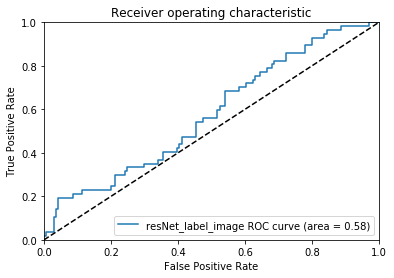

0.598004935192


In [14]:
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc
print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitresNet_label_image.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]
# print y_test
# print 'probas', probas
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='resNet_label_image ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))


In [23]:
def compute_prediction_2(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION_2)
#     x = np.array([np.mean(np.load((FEATURE_FOLDER+'%s.npy') % str(id)), axis=0).flatten() for id in df['id'].tolist()])
    
    image_num = [0]
    df_2 = df['cancer'].tolist()
    print 'length of df_2', len(df_2)
    i = 0
    #x = []
    for id in df['id']:
        load_one = np.array([np.load(FEATURE_FOLDER+'%s.npy' %str(id))])
#         print 'load_one shape: ', load_one.shape (1,64,7,7,512)
        a,b,c,d,e = load_one.shape
        load_one = load_one.reshape(a*b, c*d*e)
        if i == 0:
            x = load_one
        else:
            x = np.vstack((x,load_one))
#         print 'load one shape', load_one.shape
#         print 'x shape:', x.shape
        temp = image_num[-1]
        temp += b
        image_num.append(temp)
#         image_num += b
#         print 'lenght of df before', len(df_2)
        df_2[i:i] = [df_2[i]] * (b-1)
        i = image_num[-1]
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    print "pred before", pred
    dic = {}
    dic['cancer'] = pred
    print "length of prediction", len(dic['cancer'])
    print 'image num length', len(image_num)
#     df['cancer'] = pred
    df_3 = pd.DataFrame(dic, columns = ['cancer'])
    print 'pred before to csv df_3 finishing'
    
    # average probability
    print "predict after : "
    pred_after = []
    count = 0
    while count < len(image_num) - 1:
        start = image_num[count]
        end = image_num[count + 1]
        val = np.mean(pred[start:end])
        pred_after.append(val)
        count += 1
    print "finishing predict avg:"
    print pred_after
    df['cancer'] = pred_after
    return df

In [24]:
def save_results_2(df):
    df.to_csv(SUBMIT_OUTPUT_2, index=False)

In [25]:
df = compute_prediction_2(clf)
print("Results:")
print df
df.head()
save_results_2(df)

length of df_2 198
Prediction took 8.100 sec.

pred before [ 0.29487962  0.27785078  0.20537675 ...,  0.76002146  0.71434701
  0.65283107]
length of prediction 12136
image num length 199
pred before to csv df_3 finishing
predict after : 
finishing predict avg:
[0.26858932232841792, 0.24205686287625156, 0.22655276395954493, 0.2821957940257479, 0.2867731605727552, 0.23457435407219901, 0.234268014885536, 0.30376984569761561, 0.27344575270390981, 0.24884908657475655, 0.19384557494932234, 0.34342252945217455, 0.24692879922196426, 0.25113002131561563, 0.23915552485054203, 0.23666293698658539, 0.22346992649701169, 0.23803495938999814, 0.2611141669866715, 0.23455715543340536, 0.8318872398902335, 0.24137822228666328, 0.30668821807202179, 0.23586930399089001, 0.21071237977114762, 0.22289940370998493, 0.20505920183098134, 0.24756060234284299, 0.28458338407312372, 0.22596475942766669, 0.27717505745612359, 0.29078599624697049, 0.32713723586361571, 0.26662158500198641, 0.2277586031871795, 0.30317332

come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.268589
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.242057
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.226553
3    06a90409e4fcea3e634748b967993531         0  Public  0.282196
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.286773
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.234574
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.234268
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.303770
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.273446
9    1753250dab5fc81bab8280df13309733         0  Public  0.248849
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.193846
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.343423
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.246929
13   1fdbc07019192de4a114e090389c8330         1  Pu

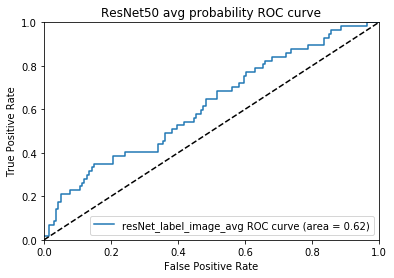

0.584901517853


In [50]:
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc
print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitresNet_label_image_Avg.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]
# print y_test
# print 'probas', probas
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='resNet_label_image_avg ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('ResNet50 avg probability ROC curve')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))


In [31]:
# compute prediction for every images of every patient
# The get max of probability for every patient(id)
def compute_prediction_3(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION_2)
    
    image_num = [0]
    df_2 = df['cancer'].tolist()
    print 'length of df_2', len(df_2)
    i = 0
    for id in df['id']:
        load_one = np.array([np.load(FEATURE_FOLDER+'%s.npy' %str(id))])
        a,b,c,d,e = load_one.shape
        load_one = load_one.reshape(a*b, c*d*e)
        if i == 0:
            x = load_one
        else:
            x = np.vstack((x,load_one))
        temp = image_num[-1]
        temp += b
        image_num.append(temp)
        df_2[i:i] = [df_2[i]] * (b-1)
        i = image_num[-1]
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    print "pred before", pred
    dic = {}
    dic['cancer'] = pred
    print "length of prediction", len(dic['cancer'])
    print 'image num length', len(image_num)
    df_3 = pd.DataFrame(dic, columns = ['cancer'])
    print 'pred before to csv df_3 finishing'
    
    # maximum probability
    print "predict after avg: "
    pred_after = []
    count = 0
    while count < len(image_num) - 1:
        start = image_num[count]
        end = image_num[count + 1]
        val = np.max(pred[start:end])
        pred_after.append(val)
        count += 1
    print "finishing predict max:"
    df['cancer'] = pred_after
    return df

In [32]:
# save max prediction for every patient id info csv file
def save_results_3(df):
    df.to_csv(SUBMIT_OUTPUT_3, index=False)

In [33]:
# compute  prediction for every patient id and save into submit_output_2 file
df = compute_prediction_3(clf)
print("Results:")
print df
df.head()
save_results_3(df)

length of df_2 198
Prediction took 8.080 sec.

pred before [ 0.29487962  0.27785078  0.20537675 ...,  0.76002146  0.71434701
  0.65283107]
length of prediction 12136
image num length 199
pred before to csv df_3 finishing
predict after avg: 
finishing predict max:
Results:
                                   id    cancer
0    026470d51482c93efc18b9803159c960  0.505281
1    031b7ec4fe96a3b035a8196264a8c8c3  0.331487
2    03bd22ed5858039af223c04993e9eb22  0.300393
3    06a90409e4fcea3e634748b967993531  0.436762
4    07b1defcfae5873ee1f03c90255eb170  0.356830
5    0b20184e0cd497028bdd155d9fb42dc9  0.309994
6    12db1ea8336eafaf7f9e3eda2b4e4fef  0.281329
7    159bc8821a2dc39a1e770cb3559e098d  0.469098
8    174c5f7c33ca31443208ef873b9477e5  0.368937
9    1753250dab5fc81bab8280df13309733  0.350893
10   1cf8e778167d20bf769669b4be96592b  0.280246
11   1e62be2c3b6430b78ce31a8f023531ac  0.547364
12   1f6333bc3599f683403d6f0884aefe00  0.314186
13   1fdbc07019192de4a114e090389c8330  0.346736
14   20

come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.505281
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.331487
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.300393
3    06a90409e4fcea3e634748b967993531         0  Public  0.436762
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.356830
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.309994
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.281329
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.469098
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.368937
9    1753250dab5fc81bab8280df13309733         0  Public  0.350893
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.280246
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.547364
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.314186
13   1fdbc07019192de4a114e090389c8330         1  Pu

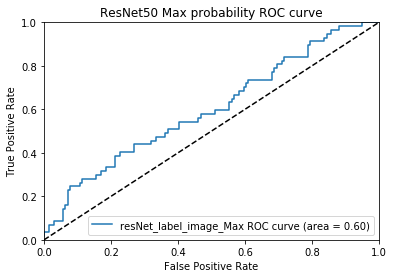

0.617193414881


In [51]:
# ROC curve for every patient using max probability
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc
print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitresNet_label_image_Max.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='resNet_label_image_Max ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('ResNet50 Max probability ROC curve')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))


In [43]:
# compute prediction for every images of every patient
# The get min of probability for every patient(id)
def compute_prediction_4(clf, verbose=True):    
    df = pd.read_csv(STAGE1_SAMPLE_SUBMISSION_2)
    image_num = [0]
    df_2 = df['cancer'].tolist()
    print 'length of df_2', len(df_2)
    i = 0
    for id in df['id']:
        load_one = np.array([np.load(FEATURE_FOLDER+'%s.npy' %str(id))])
        a,b,c,d,e = load_one.shape
        load_one = load_one.reshape(a*b, c*d*e)
        if i == 0:
            x = load_one
        else:
            x = np.vstack((x,load_one))
        temp = image_num[-1]
        temp += b
        image_num.append(temp)
        df_2[i:i] = [df_2[i]] * (b-1)
        i = image_num[-1]
    with Timer() as t:
        pred = clf.predict(x)
    if verbose: print("Prediction took %.03f sec.\n" % t.interval)
    print "pred before", pred
    dic = {}
    dic['cancer'] = pred
    print "length of prediction", len(dic['cancer'])
    print 'image num length', len(image_num)
    df_3 = pd.DataFrame(dic, columns = ['cancer'])
    print 'pred before to csv df_3 finishing'
    
    # minimum probability
    print "predict after avg: "
    pred_after = []
    count = 0
    while count < len(image_num) - 1:
        start = image_num[count]
        end = image_num[count + 1]
        val = np.min(pred[start:end])
        pred_after.append(val)
        count += 1
    print "finishing predict min:"
    print pred_after
    df['cancer'] = pred_after
    return df

In [44]:
# save min prediction for every patient id info csv file
def save_results_4(df):
    df.to_csv(SUBMIT_OUTPUT_4, index=False)

In [46]:
# compute mean prediction for every patient id and save into submit_output_2 file
df = compute_prediction_4(clf)
print("Results:")
print df
df.head()
save_results_4(df)

length of df_2 198
Prediction took 8.150 sec.

pred before [ 0.29487962  0.27785078  0.20537675 ...,  0.76002146  0.71434701
  0.65283107]
length of prediction 12136
image num length 199
pred before to csv df_3 finishing
predict after avg: 
finishing predict min:
[0.17461522870596036, 0.1867087225015843, 0.16417617013529695, 0.16549961387689666, 0.18775639467658692, 0.17739606168265329, 0.18163750470931592, 0.21612519723110002, 0.16935706929458272, 0.17720283560248001, 0.13909827620780255, 0.15677260856937858, 0.19125695457441128, 0.17710656621419082, 0.17777178029180413, 0.13784476005193699, 0.17139689244924117, 0.17890108050579231, 0.17728666367012802, 0.15411610940692433, 0.35100052766878748, 0.20215243661636578, 0.2029142622779016, 0.17236363133888516, 0.12920098618208611, 0.19302450262154597, 0.14369657553301904, 0.17492112413190228, 0.23242423264500581, 0.15970830073311343, 0.19119121243764678, 0.18623408855819143, 0.19851917202412828, 0.20473726578451626, 0.18811776813502376, 0.

come into file
merge csv                                    id  cancer_x   Usage  cancer_y
0    026470d51482c93efc18b9803159c960         1  Public  0.174615
1    031b7ec4fe96a3b035a8196264a8c8c3         1  Public  0.186709
2    03bd22ed5858039af223c04993e9eb22         0  Public  0.164176
3    06a90409e4fcea3e634748b967993531         0  Public  0.165500
4    07b1defcfae5873ee1f03c90255eb170         1  Public  0.187756
5    0b20184e0cd497028bdd155d9fb42dc9         0  Public  0.177396
6    12db1ea8336eafaf7f9e3eda2b4e4fef         0  Public  0.181638
7    159bc8821a2dc39a1e770cb3559e098d         0  Public  0.216125
8    174c5f7c33ca31443208ef873b9477e5         0  Public  0.169357
9    1753250dab5fc81bab8280df13309733         0  Public  0.177203
10   1cf8e778167d20bf769669b4be96592b         0  Public  0.139098
11   1e62be2c3b6430b78ce31a8f023531ac         1  Public  0.156773
12   1f6333bc3599f683403d6f0884aefe00         0  Public  0.191257
13   1fdbc07019192de4a114e090389c8330         1  Pu

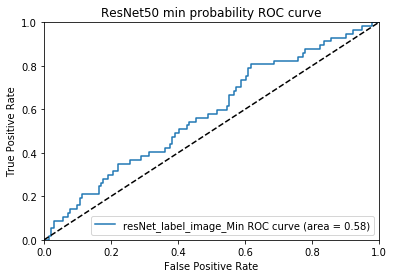

0.623411711605


In [52]:
# ROC curve for every patient using max probability
import pandas as pd
import numpy as np 
import pylab as pl 
from sklearn.metrics import roc_curve, auc
print 'come into file'
df_1 = pd.read_csv('stage1_solution.csv')
df_2 = pd.read_csv('submitresNet_label_image_Min.csv')
merge = df_1.merge(df_2, on = 'id')
print 'merge csv', merge
keep_cols = ['cancer_x', 'cancer_y']
df = merge[keep_cols]
print 'finish reading csv file'
y_test = np.array(df)[:,0]
probas = np.array(df)[:,1]
# print y_test
# print 'probas', probas
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas)
print 'thresholds', thresholds
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

pl.clf()
pl.plot(fpr, tpr, label='resNet_label_image_Min ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('ResNet50 min probability ROC curve')
pl.legend(loc="lower right")
pl.show()

from sklearn import metrics
print (metrics.log_loss(y_test, probas))
